# Querying the MRIQC Web API

This notebook shows how the web-API can be leveraged to analyze the image quality metrics (IQMs) that have been extracted with MRIQC

This notebook is a derivative work of https://gist.github.com/chrisfilo/eccdb8b98f8e74d24a3395a49fbadf03

In [1]:
import pandas as pd
from json import load
import urllib.request, json 
from pandas.io.json import json_normalize
import seaborn as sns
import pylab as plt
import multiprocessing as mp
import numpy as np
from sklearn.manifold import TSNE
%matplotlib inline

## Preparation

Let's define a function that will query the appropriate endpoint and a helper function to plot some distributions (at the bottom of this notebook).

In [2]:
def get_iqms(modality, versions=None, software='mriqc'):
    """
    Grab all iqms for the given modality and the list of versions
    """
    url_root = 'https://mriqc.nimh.nih.gov/api/v1/{modality}?{query}'
    page = 1
    dfs = []
    
    if versions is None:
        versions = ['*']

    for version in versions:
        while True:
            query = []
            
            if software is not None:
                query.append('"provenance.software":"%s"' % software)
            
            if version != '*':
                query.append('"provenance.version":"%s"' % version)
                
            page_url = url_root.format(
                modality=modality,
                query='where={%s}&page=%d' % (','.join(query), page)
            )
            with urllib.request.urlopen(page_url) as url:
                data = json.loads(url.read().decode())
                dfs.append(json_normalize(data['_items']))
                if 'next' not in data['_links'].keys():
                    break
                else:
                    page += 1

    # Compose a pandas dataframe
    return pd.concat(dfs, ignore_index=True)


def plot_measure(data, xlabel=None, label=None, ax=None, min=None, max=None):
    """
    Distribution plot of a given measure
    """
    sns.distplot(data, ax=ax, label=label)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if min is None:
        min = np.percentile(data, 0.5)
    
    if max is None:
        max = np.percentile(data, 99.5)
    ax.set_xlim((min, max))

## Fetch IQMs

Let's fetch IQMs for the two principal modalities of MRIQC, T1-weighted images and BOLD-fMRI. Filter out repeated images to obtain unique records.

In [ ]:
# T1
df_t1w = get_iqms('T1w', software=None)
df_t1w_unique = df_t1w.drop_duplicates(subset=['provenance.md5sum'])

# BOLD
df_bold = get_iqms('bold')
df_bold_unique = df_bold.drop_duplicates(subset=['provenance.md5sum'])

## Evolution of IQMs submission

This code generates Figure 3A of the abstract

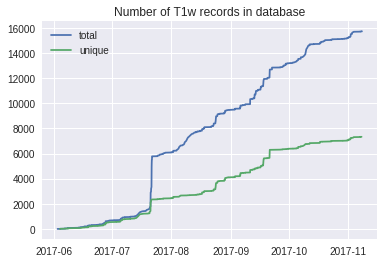

In [4]:
import datetime
from dateutil import parser
import matplotlib.dates as mdates

dates_t1w = [parser.parse(d) for d in df_t1w['_created'].values]
dates_t1w.sort()

dates_t1w_u = [parser.parse(d) for d in df_t1w_unique['_created'].values]
dates_t1w_u.sort()
# mindate = dates_t1w[0]
ax = plt.subplot(111)
ax.plot(dates_t1w, list(range(1, len(dates_t1w) + 1)), label='total')
ax.plot(dates_t1w_u, list(range(1, len(dates_t1w_u) + 1)), label='unique')
ax.set_title('Number of T1w records in database')
ax.legend()

plt.savefig("fig03a-0.svg", bbox_inches='tight', transparent=False, pad_inches=0)

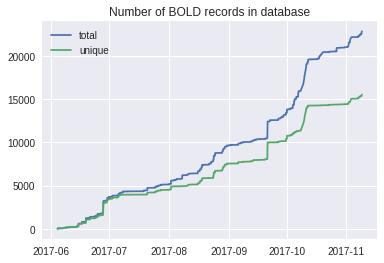

In [5]:
dates_bold = [parser.parse(d) for d in df_bold['_created'].values]
dates_bold.sort()
dates_bold_u = [parser.parse(d) for d in df_bold_unique['_created'].values]
dates_bold_u.sort()
# mindate = dates_t1w[0]
ax = plt.subplot(111)
ax.plot(dates_bold, list(range(1, len(dates_bold) + 1)), label='total')
ax.plot(dates_bold_u, list(range(1, len(dates_bold_u) + 1)), label='unique')
ax.set_title('Number of BOLD records in database')
ax.legend()
plt.savefig("fig03a-1.svg", bbox_inches='tight', transparent=False, pad_inches=0)

## Playing with T1w IQMs

Let's plot some of the IQMs for the T1w modality. First, let's check the names of the IQMs. These measures are explained in the documentation (http://mriqc.readthedocs.io/en/stable/iqms/t1w.html)

In [6]:
print(','.join([l for l in df_t1w.columns 
                if not l.startswith('_') and not l.startswith('bids_meta') and not l.startswith('provenance')]))

cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,icvs_wm,inu_med,inu_range,qi_1,qi_2,rpve_csf,rpve_gm,rpve_wm,size_x,size_y,size_z,snr_csf,snr_gm,snr_total,snr_wm,snrd_csf,snrd_gm,snrd_total,snrd_wm,spacing_x,spacing_y,spacing_z,summary_bg_k,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_bg_stdv,summary_csf_k,summary_csf_mad,summary_csf_mean,summary_csf_median,summary_csf_n,summary_csf_p05,summary_csf_p95,summary_csf_stdv,summary_gm_k,summary_gm_mad,summary_gm_mean,summary_gm_median,summary_gm_n,summary_gm_p05,summary_gm_p95,summary_gm_stdv,summary_wm_k,summary_wm_mad,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max


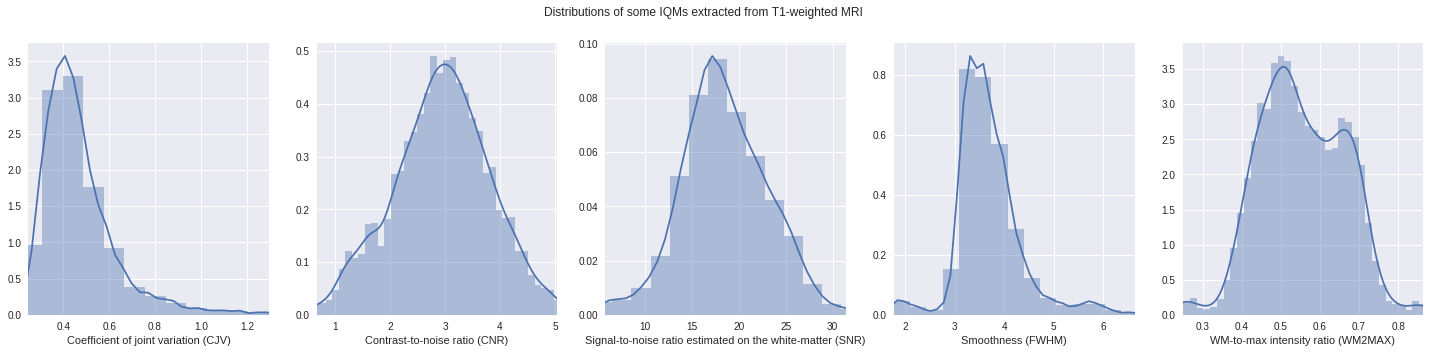

In [7]:
f, ax = plt.subplots(1, 5, figsize=(25,5))
plot_measure(df_t1w_unique.cjv, xlabel='Coefficient of joint variation (CJV)', ax=ax[0])
plot_measure(df_t1w_unique.cnr, xlabel='Contrast-to-noise ratio (CNR)', ax=ax[1])
plot_measure(df_t1w_unique.snr_wm, xlabel='Signal-to-noise ratio estimated on the white-matter (SNR)', ax=ax[2])
plot_measure(df_t1w_unique.fwhm_avg, xlabel='Smoothness (FWHM)', ax=ax[3])
plot_measure(df_t1w_unique.wm2max, xlabel='WM-to-max intensity ratio (WM2MAX)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from T1-weighted MRI')
plt.savefig("fig03b-0.svg", bbox_inches='tight', transparent=False, pad_inches=0)

## Playing with BOLD IQMs

Let's plot some of the IQMs for the BOLD modality. First, let's check the names of the IQMs. These measures are explained in the documentation (http://mriqc.readthedocs.io/en/stable/iqms/bold.html)

In [8]:
print(','.join([l for l in df_bold.columns 
                if not l.startswith('_') and not l.startswith('bids_meta') and not l.startswith('provenance')]))

aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,gcor,gsr_x,gsr_y,size_t,size_x,size_y,size_z,snr,spacing_tr,spacing_x,spacing_y,spacing_z,summary_bg_k,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_bg_stdv,summary_fg_k,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr


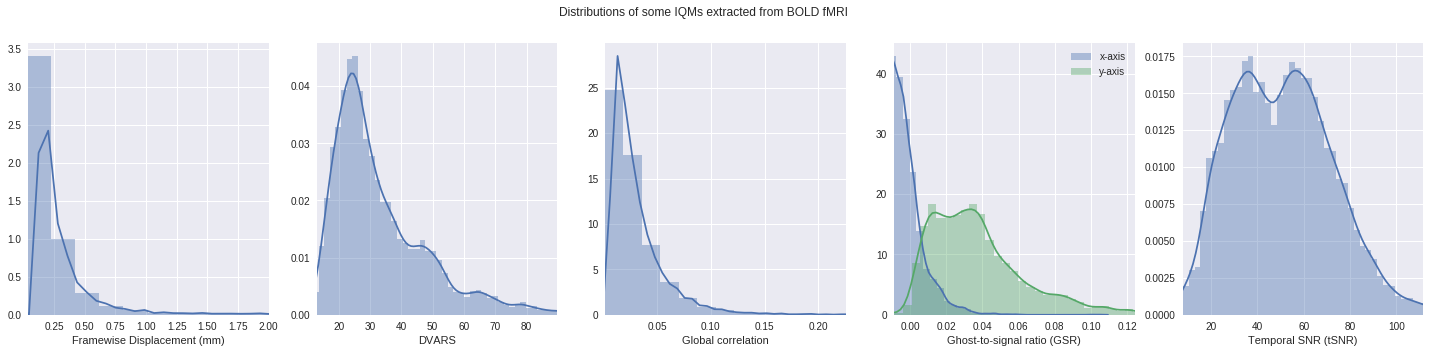

In [9]:
f, ax = plt.subplots(1, 5, figsize=(25,5))
plot_measure(df_bold_unique[df_bold_unique.fd_mean < 10].fd_mean, xlabel='Framewise Displacement (mm)', max=2, ax=ax[0])
plot_measure(df_bold_unique[df_bold_unique.dvars_nstd < 100].dvars_nstd, xlabel='DVARS', ax=ax[1])
plot_measure(df_bold_unique.gcor, xlabel='Global correlation', ax=ax[2])
plot_measure(df_bold_unique.gsr_x, label='x-axis', ax=ax[3])
plot_measure(df_bold_unique.gsr_y, xlabel='Ghost-to-signal ratio (GSR)', label='y-axis', ax=ax[3])
ax[3].legend()
plot_measure(df_bold_unique.tsnr, xlabel='Temporal SNR (tSNR)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from BOLD fMRI')
plt.savefig("fig03b-1.png", bbox_inches='tight', transparent=False, pad_inches=0, facecolor='white')

# Look at T-Statistic Neighbor Embedding of QC Metrics
Scikit-Learns TSNE function: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Code above this point written by Oscar Esteban
TSNE analysis suggested by Satrajit Ghosh

In [95]:
# Save out snapshot of data used in the below analyses
# Data downloaded at 14:48:54 2018-01-19
df_t1w_unique.to_csv('t1_unique.csv', index = False)
df_bold_unique.to_csv('bold_unique.csv', index = False)

## T1w TSNE

In [10]:
metric_columns = [l for l in df_t1w.columns 
                if not l.startswith('_') and not l.startswith('bids_meta') and not l.startswith('provenance')]

In [44]:
metric_columns = [l for l in df_t1w.columns 
                if not l.startswith('_') and not l.startswith('bids_meta') and not l.startswith('provenance')]
meta_columns =[l for l in df_t1w_unique.columns 
                if not l.startswith('_') and l.startswith('bids_meta') and not l.startswith('provenance')]

In [21]:
X = df_t1w_unique.loc[:,metric_columns]
X = X.loc[X.isnull().sum(1)==0,:]
res = TSNE().fit_transform(X)

In [48]:
res_df = df_t1w_unique.loc[df_t1w_unique.loc[:,metric_columns].isnull().sum(1)==0,meta_columns]
res_df['x'] = res[:,0]
res_df['y'] = res[:,1]

In [23]:
x = res[:,0]
y = res[:,1]

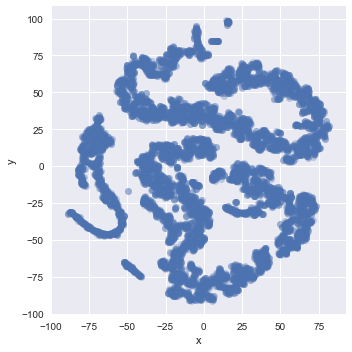

In [61]:
sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0, scatter_kws = {"alpha":0.3 })

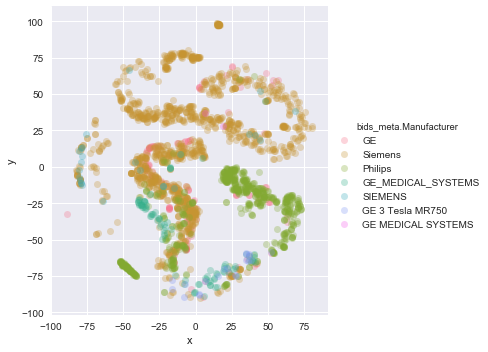

In [55]:
sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0,hue = "bids_meta.Manufacturer", scatter_kws = {"alpha":0.3 })

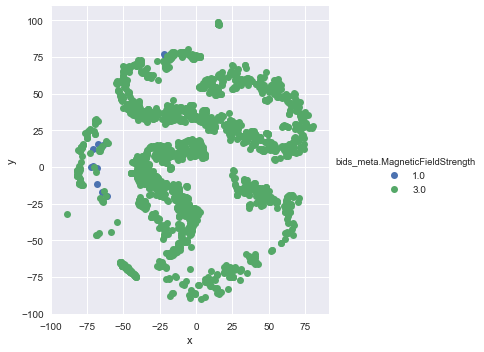

In [58]:
sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0,hue = "bids_meta.MagneticFieldStrength", scatter_kws = {"alpha":1 })

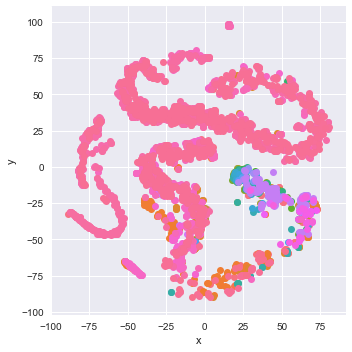

In [94]:
sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0,hue = "bids_meta.RepetitionTime", scatter_kws = {"alpha":1 }, legend = False)

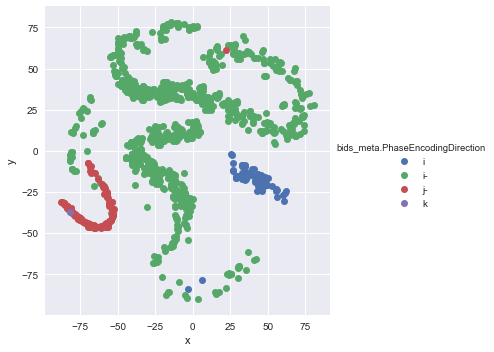

In [60]:
sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0,hue = "bids_meta.PhaseEncodingDirection", scatter_kws = {"alpha":1 })

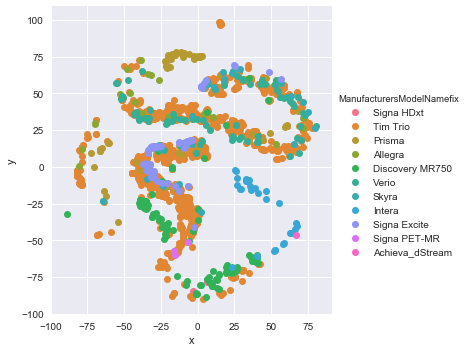

In [78]:
sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0,hue = "ManufacturersModelNamefix", scatter_kws = {"alpha":1 })

In [86]:
meta_to_plot = ["bids_meta.Manufacturer",
                "ManufacturersModelNamefix",
                "bids_meta.PhaseEncodingDirection",
                "bids_meta.MagneticFieldStrength",
                "bids_meta.RepetitionTime",
                "bids_meta.ReceiveCoilName"]

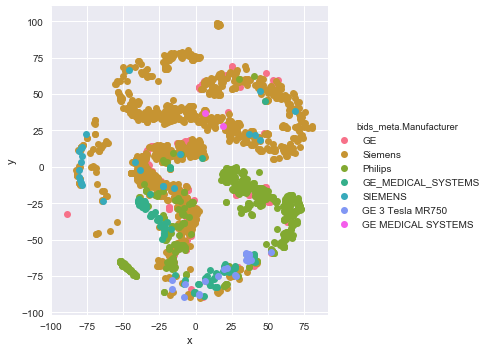

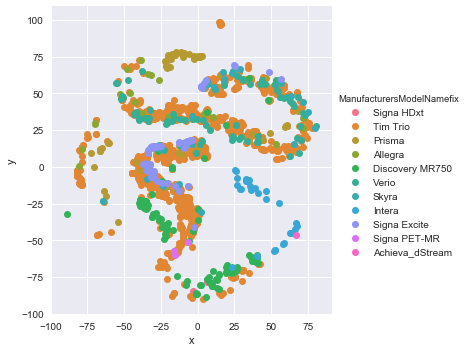

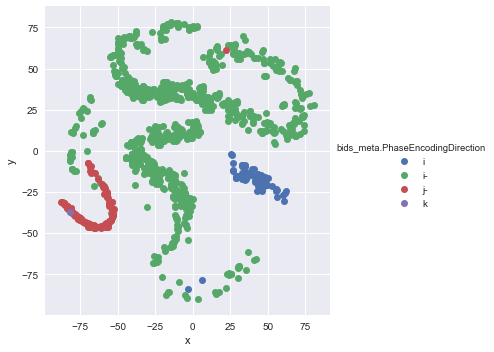

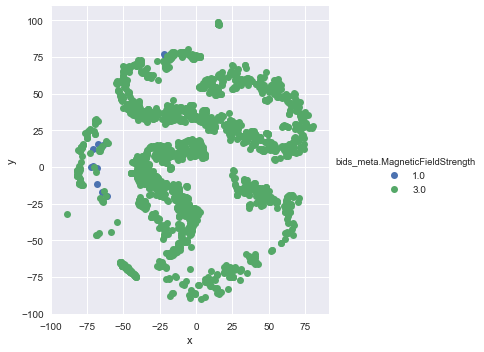

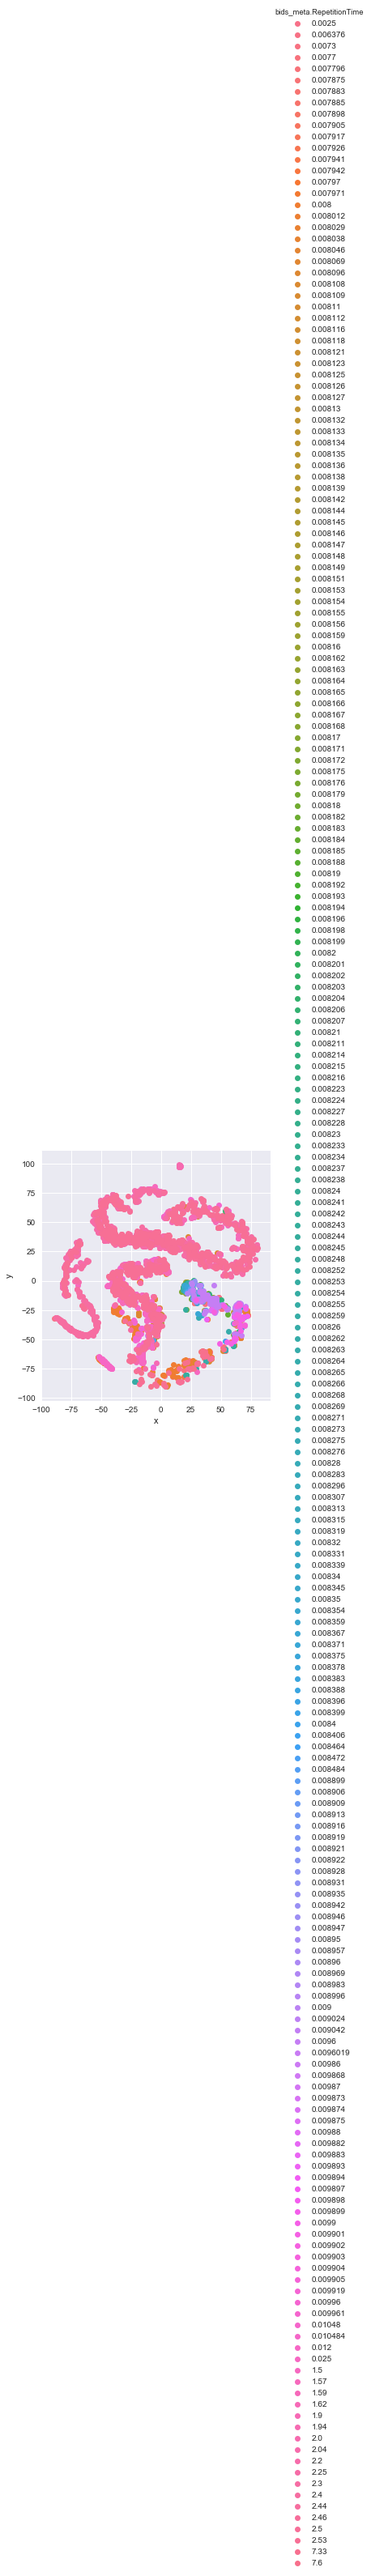

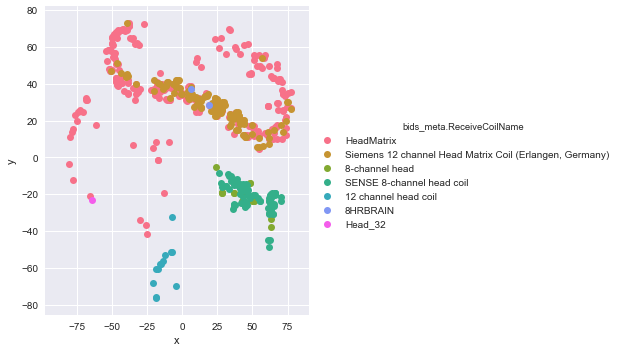

In [93]:
#fig, axs = plt.subplots(2,3, figsize = (10,10))
for mtp, ax in zip(meta_to_plot, axs.flatten()):
    sns.lmplot('x','y', res_df, fit_reg = False, n_boot = 0,hue = mtp, scatter_kws = {"alpha":1 })
    #if mtp == "bids_meta.RepetitionTime":
    #    ax.legend_.remove()

In [85]:
ax.legend

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12d7353c8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13011bf98>], dtype=object)

In [70]:
model_dict = {'Signa_HDxt': 'Signa HDxt',
        'SIGNA_PET_MR': 'Signa PET-MR',
        'SIGNA_EXCITE': 'Signa Excite',
        'TrioTim': 'Tim Trio',
        'Magnetom Trio' : 'Tim Trio',
        'TIM TRIO': 'Tim Trio',
        'MAGNETOM Trio': 'Tim Trio',
        'TRIOTIM': 'Tim Trio',
        'Trio': 'Tim Trio',
        'Trio TIM': 'Tim Trio',
        'TRIO': 'Tim Trio',
        'Prisma_fit': 'Prisma',
        'Prisma': 'Prisma',
        'Skyra': 'Skyra',
        'Intera': 'Intera',
        'Allegra': 'Allegra',
        'Verio': 'Verio',
        'DISCOVERY MR750': 'Discovery MR750',
        'DISCOVERY_MR750': 'Discovery MR750',
        'DISCOVERY_MR750w': 'Discovery MR750',
        'Achieva_dStream': 'Achieva_dStream',
        'N/A': np.nan,
        '': np.nan}

In [77]:
mlist = []
bad = []
for mm in res_df['bids_meta.ManufacturersModelName']:
    try:
        mlist.append(model_dict[mm])
    except KeyError:
        if pd.notnull(mm):
            bad.append(mm)
        mlist.append(np.nan)
res_df['ManufacturersModelNamefix'] = mlist

In [76]:
bad

[]

In [35]:
df_t1w_unique.loc[:,[l for l in df_t1w_unique.columns 
                if not l.startswith('_') and l.startswith('bids_meta') and not l.startswith('provenance')]].notnull().sum(0)

bids_meta.AccelNumReferenceLines             264
bids_meta.AccelerationFactorPE               264
bids_meta.AcquisitionMatrix                  264
bids_meta.ConversionSoftware                 713
bids_meta.ConversionSoftwareVersion          610
bids_meta.DeviceSerialNumber                 484
bids_meta.EchoTime                          3447
bids_meta.EchoTrainLength                    277
bids_meta.EffectiveEchoSpacing               212
bids_meta.FlipAngle                         2702
bids_meta.ImageType                          567
bids_meta.ImagingFrequency                   265
bids_meta.InPlanePhaseEncodingDirection      279
bids_meta.InstitutionAddress                 116
bids_meta.InstitutionName                    222
bids_meta.InversionTime                     1014
bids_meta.MRAcquisitionType                  438
bids_meta.MagneticFieldStrength             2049
bids_meta.Manufacturer                      2230
bids_meta.ManufacturersModelName            1491
bids_meta.NumberOfAv

In [38]:
df_t1w_unique.loc[:,'bids_meta.subject_id']

0        7d3295fffae7b7c2fd051352e4d54cca27c22ce7f75de3...
1        29db0c6782dbd5000559ef4d9e953e300e2b479eed26d8...
2        349c41201b62db851192665c504b350ff98c6b45fb62a8...
3        6208ef0f7750c111548cf90b6ea1d0d0a66f6bff40dbef...
4        7a61b53701befdae0eeeffaecc73f14e20b537bb0f8b91...
5        e629fa6598d732768f7c726b4b621285f9c3b85303900a...
6        16dc368a89b428b2485484313ba67a3912ca03f2b2b424...
7        8241649609f88ccd2a0a5b233a07a538ec313ff6adf695...
8        8722616204217eddb39e7df969e0698aed8e599ba62ed2...
9        41cfc0d1f2d127b04555b7246d84019b4d27710a3f3aff...
10       eb1e33e8a81b697b75855af6bfcdbcbf7cbbde9f94962c...
12       7edd2043c0c032f7d2b63563fab2c802d42f023dae4f6e...
13       4fac6dbe26e823ed6edf999c63fab3507119cf3cbfb560...
14       888b19a43b151683c87895f6211d9f8640f97bdc8ef32f...
15       b16d9e2bb44a4b728d0431a21c103e1c018b17248d3c95...
16       76a00ed73f38046ec631b719ec46144b6c13f558c884eb...
17       2d54ab36581c7e905efeb3ca6973038a83cfbe1cb1c253.

In [29]:
print(','.join([l for l in df_bold.columns 
                if not l.startswith('_') and l.startswith('bids_meta') and not l.startswith('provenance')]))

bids_meta.CogAtlasID,bids_meta.CogPOID,bids_meta.ConversionSoftware,bids_meta.ConversionSoftwareVersion,bids_meta.DeviceSerialNumber,bids_meta.EchoTime,bids_meta.EchoTrainLength,bids_meta.EffectiveEchoSpacing,bids_meta.FlipAngle,bids_meta.HardcopyDeviceSoftwareVersion,bids_meta.ImageType,bids_meta.ImagingFrequency,bids_meta.InPlanePhaseEncodingDirection,bids_meta.InstitutionAddress,bids_meta.InstitutionName,bids_meta.Instructions,bids_meta.InversionTime,bids_meta.MRAcquisitionType,bids_meta.MagneticFieldStrength,bids_meta.Manufacturer,bids_meta.ManufacturersModelName,bids_meta.MultibandAccelerationFactor,bids_meta.NumberOfAverages,bids_meta.NumberOfPhaseEncodingSteps,bids_meta.NumberOfVolumesDiscardedByScanner,bids_meta.ParallelAcquisitionTechnique,bids_meta.ParallelReductionFactorInPlane,bids_meta.PartialFourier,bids_meta.PatientPosition,bids_meta.PercentPhaseFieldOfView,bids_meta.PhaseEncodingDirection,bids_meta.PixelBandwidth,bids_meta.ProtocolName,bids_meta.PulseSequenceDetails,bid